In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import multiprocessing as mp

In [50]:
plik_1 = pd.read_parquet('plik_1.parquet')
plik_2 = pd.read_parquet('plik_2.parquet')

In [51]:
df = pd.concat([plik_1, plik_2], ignore_index=True)

In [52]:
print("Typy danych w DataFrame:\n", df.dtypes)

memory_usage = df.memory_usage(deep=True).sum()
print(f'Wielkość pamięci zajmowana: {memory_usage / 1024 / 1024:.2f} MB')

Typy danych w DataFrame:
 sid                     int64
sid_profile             int64
post_id                object
profile_id              int64
date                   object
post_type               int64
description            object
likes                   int64
comments                int64
username               object
bio                    object
following               int64
followers               int64
num_posts               int64
is_business_account      bool
lang                   object
category               object
dtype: object
Wielkość pamięci zajmowana: 2949.80 MB


Zadanie 2

Wielkość pamięci zajmowana przed optymalizacją: 2949.80 MB
Wielkość pamięci zajmowana po optymalizacji: 2189.74 MB


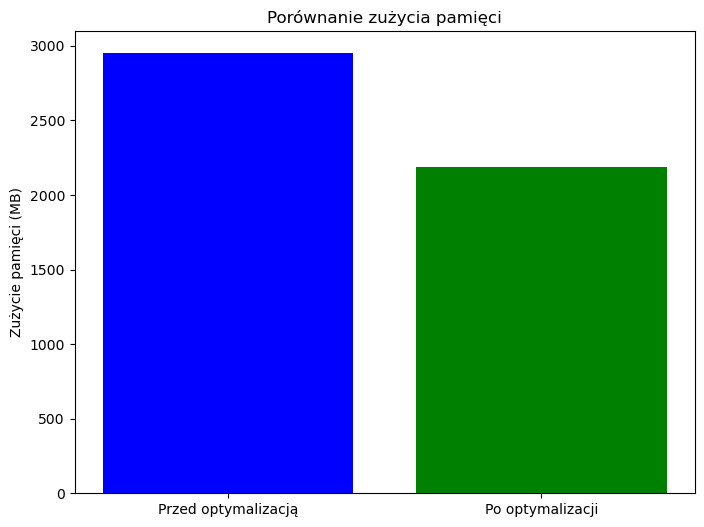

In [53]:
original_memory_usage = df.memory_usage(deep=True).sum()
print(f'Wielkość pamięci zajmowana przed optymalizacją: {original_memory_usage / 1024 / 1024:.2f} MB')

def optimize_dataframe(df):
    for col in df.columns:
        col_type = df[col].dtype

        if col_type == 'float64':
            df[col] = df[col].astype('float32')
        elif col_type == 'int64':
            df[col] = df[col].astype('int32')
        elif col_type == 'object':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')

    return df

df_optimized = optimize_dataframe(df)

optimized_memory_usage = df_optimized.memory_usage(deep=True).sum()
print(f'Wielkość pamięci zajmowana po optymalizacji: {optimized_memory_usage / 1024 / 1024:.2f} MB')

memory_usage_comparison = [original_memory_usage / 1024 / 1024, optimized_memory_usage / 1024 / 1024]

plt.figure(figsize=(8, 6))
plt.bar(['Przed optymalizacją', 'Po optymalizacji'], memory_usage_comparison, color=['blue', 'green'])
plt.ylabel('Zużycie pamięci (MB)')
plt.title('Porównanie zużycia pamięci')
plt.show()

Zadanie 3

grupowanie

In [54]:
def perform_operations(df):
    group_agg = df.groupby('category', observed=False).agg({'likes': 'mean'})
    filtered_df = df[df['comments'] > 10]
    df['double_followers'] = df['followers'] * 2

    return group_agg, filtered_df, df


In [55]:
def measure_time(df):
    start_time = time.time()
    perform_operations(df)
    end_time = time.time()
    return end_time - start_time

Mierzenie czasu operacji na oryginalnych danych...
Czas operacji na oryginalnych danych: 0.1303 sekund
Mierzenie czasu operacji na zoptymalizowanych danych...
Czas operacji na zoptymalizowanych danych: 0.1158 sekund


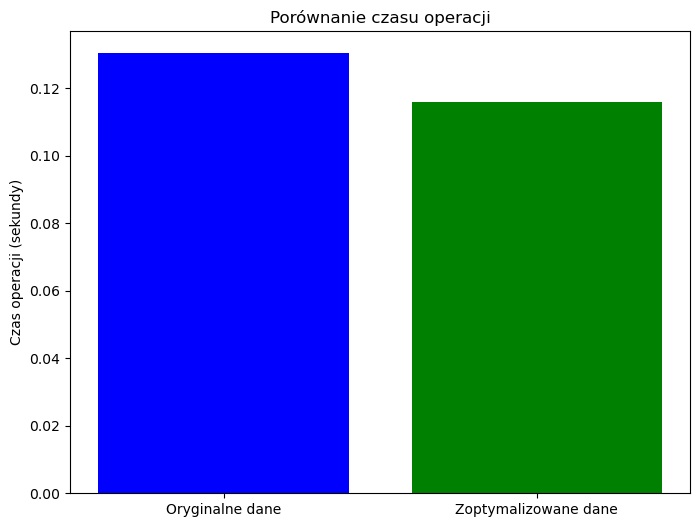

In [56]:
print("Mierzenie czasu operacji na oryginalnych danych...")
time_original = measure_time(df)
print(f'Czas operacji na oryginalnych danych: {time_original:.4f} sekund')

print("Mierzenie czasu operacji na zoptymalizowanych danych...")
time_optimized = measure_time(df_optimized)
print(f'Czas operacji na zoptymalizowanych danych: {time_optimized:.4f} sekund')

times_comparison = [time_original, time_optimized]

plt.figure(figsize=(8, 6))
plt.bar(['Oryginalne dane', 'Zoptymalizowane dane'], times_comparison, color=['blue', 'green'])
plt.ylabel('Czas operacji (sekundy)')
plt.title('Porównanie czasu operacji')
plt.show()

Zadanie 4

In [57]:
df.to_csv('dane.csv', index=False)

2 pliki = 384,625Mb vs 1 plik= 959,247Mb

In [2]:
def load_csv(filepath, chunksize=None):
    if chunksize:
        return pd.concat(pd.read_csv(filepath, chunksize=chunksize))
    else:
        return pd.read_csv(filepath)


start_time = time.time()
df_full = load_csv('dane.csv')
end_time = time.time()
print(f"Czas wczytywania całego pliku na raz: {end_time - start_time:.4f} sekund")


chunk_sizes = [1000, 5000, 10000]
for size in chunk_sizes:
    start_time = time.time()
    df_chunks = load_csv('dane.csv', chunksize=size)
    end_time = time.time()
    print(f"Czas wczytywania pliku z chunksize={size}: {end_time - start_time:.4f} sekund")


def load_csv_multiprocessing(filepath, chunk_size, num_processes):
    chunks = pd.read_csv(filepath, chunksize=chunk_size)
    with mp.Pool(processes=num_processes) as pool:
        dfs = pool.map(pd.concat, chunks)
    return pd.concat(dfs)


num_cores = mp.cpu_count()
for multiplier in [1, 2]:
    num_processes = (num_cores - 2) * multiplier
    chunk_size = 5000
    start_time = time.time()
    df_multiprocessing = load_csv_multiprocessing('dane.csv', chunk_size, num_processes)
    end_time = time.time()
    print(f"Czas wczytywania pliku z multiprocessingu (procesy={num_processes}): {end_time - start_time:.4f} sekund")

Czas wczytywania całego pliku na raz: 23.0776 sekund
Czas wczytywania pliku z chunksize=1000: 38.3144 sekund
Czas wczytywania pliku z chunksize=5000: 27.2241 sekund
Czas wczytywania pliku z chunksize=10000: 20.6464 sekund


TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"